In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

In [2]:
uhi_data = pd.read_csv("/Users/beas28/Desktop/info Challenge/uhi_data_processed.csv").dropna()
model_data = uhi_data[['B01', 'B02', 'B03', 'B04','B05', 'B06', 'B07', 'B08','B8A', 'B11', 'B12', 'NDVI', 'NDMI', 'NDBI', 'NDWI', 'UI', 'STI','B11_B12_ratio', 'impervious_estimate', 'veg_fraction', 'UHI Index']]

B01                    0.385987
impervious_estimate    0.358331
NDWI                   0.355945
B12                    0.328981
B04                    0.324930
B02                    0.320343
NDBI                   0.312030
B05                    0.306919
B03                    0.303466
B11                    0.080859
B06                   -0.203595
B08                   -0.248342
B07                   -0.276566
B8A                   -0.300770
NDMI                  -0.312030
UI                    -0.313697
veg_fraction          -0.358331
NDVI                  -0.358334
STI                   -0.418860
B11_B12_ratio         -0.418860
dtype: float64


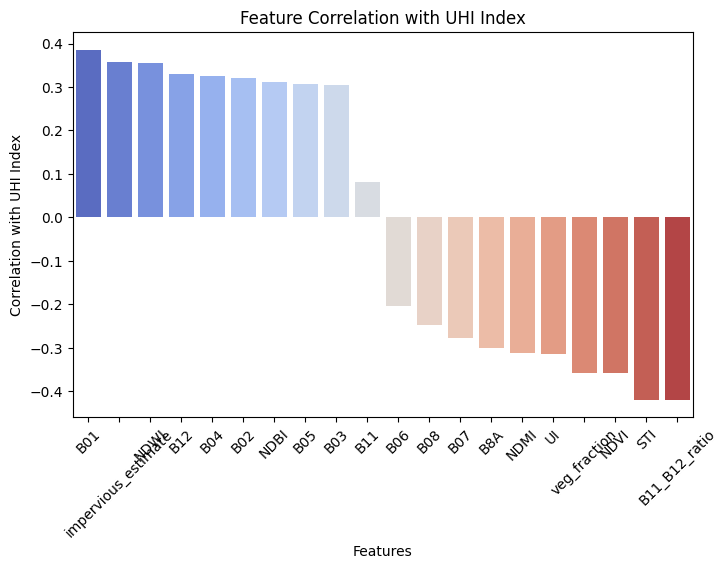

Selected Features: Index(['B01', 'impervious_estimate', 'NDWI', 'B12', 'B04', 'B02', 'NDBI',
       'B05', 'B03', 'B8A', 'NDMI', 'UI', 'veg_fraction', 'NDVI', 'STI',
       'B11_B12_ratio'],
      dtype='object')


In [3]:
UHI_Feature = uhi_data.drop(columns=['Longitude', 'Latitude', 'UHI Index'])
UHI_Target = uhi_data['UHI Index']
correlation_with_UHI = UHI_Feature.corrwith(UHI_Target)


# Sort correlation values
correlation_with_UHI = correlation_with_UHI.sort_values(ascending=False)
print(correlation_with_UHI)

# Plot the correlation as a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=correlation_with_UHI.index, y=correlation_with_UHI.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Features")
plt.ylabel("Correlation with UHI Index")
plt.title("Feature Correlation with UHI Index")
plt.show()

# Set a correlation threshold (e.g., > 0.3)
selected_features = correlation_with_UHI[correlation_with_UHI.abs() > 0.3].index

# Keep only selected features
X_selected = UHI_Feature[selected_features]

print("Selected Features:", selected_features)

In [4]:
columns_to_check = ['B01', 'B02', 'B03', 'B04','B05', 'B06', 'B07', 'B08','B8A', 'B11', 'B12', 'NDVI', 'NDMI', 'NDBI', 'NDWI', 'UI', 'STI',	'B11_B12_ratio', 'impervious_estimate', 'veg_fraction']
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
# Resetting the index of the dataset
uhi_data=uhi_data.reset_index(drop=True)
uhi_data

,Longitude,Latitude,UHI Index,B01,B02,B03,B04,B05,B06,B07,...,B12,NDVI,NDMI,NDBI,NDWI,UI,STI,B11_B12_ratio,veg_fraction,impervious_estimate
0,-77.302700,39.109905,0.993571,1427.0,1881.0,1936.0,1990.0,2280.0,2362.0,2450.0,...,2349.0,0.087575,-0.044896,0.044896,-0.101207,0.159517,1.104725,1.104725,0.087575,0.912425
1,-77.302690,39.109855,0.994674,1427.0,2250.0,2240.0,2344.0,2280.0,2362.0,2450.0,...,2349.0,0.087227,0.036570,-0.036570,-0.109698,0.071207,1.104725,1.104725,0.087227,0.912773
2,-77.302677,39.109960,0.993571,1427.0,1986.0,2092.0,2234.0,2133.0,2729.0,2979.0,...,2227.0,0.085551,-0.005811,0.005811,-0.118044,0.149283,1.204760,1.204760,0.085551,0.914449
3,-77.302630,39.110017,0.993571,1427.0,1907.0,2060.0,2084.0,2133.0,2729.0,2979.0,...,2227.0,0.096271,-0.029745,0.029745,-0.102005,0.169063,1.204760,1.204760,0.096271,0.903729
4,-77.302595,39.109767,0.993571,1427.0,1764.0,2000.0,1990.0,1963.0,2529.0,2921.0,...,2082.0,0.145923,0.032882,-0.032882,-0.143469,0.172608,1.200768,1.200768,0.145923,0.854077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24738,-76.930002,39.090400,0.995777,1313.0,1340.0,1420.0,1367.0,1687.0,2673.0,3286.0,...,1793.0,0.348582,0.059330,-0.059330,-0.331765,0.304438,1.401562,1.401562,0.348582,0.651418
24739,-76.929992,39.090818,0.991366,1313.0,1342.0,1603.0,1362.0,1952.0,3562.0,4088.0,...,1981.0,0.589388,0.310954,-0.310954,-0.533673,0.347435,1.398788,1.398788,0.589388,0.410612
24740,-76.929982,39.090512,0.993571,1313.0,1313.0,1483.0,1352.0,1687.0,2673.0,3286.0,...,1793.0,0.491538,0.224263,-0.224263,-0.455680,0.313643,1.401562,1.401562,0.491538,0.508462
24741,-76.929977,39.090722,0.991366,1313.0,1295.0,1456.0,1317.0,1761.0,2889.0,2973.0,...,1893.0,0.465395,0.181669,-0.181669,-0.425188,0.317523,1.320655,1.320655,0.465395,0.534605


In [5]:
# most important feature for XGBoost
X = uhi_data.drop(columns=['Longitude','Latitude','UHI Index'])
y = uhi_data[['UHI Index']].values

In [6]:
X_selected = X[['B01', 'B05', 'B07', 'B8A', 'B11', 'B12', 'STI']]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2,random_state=123)
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [8]:
X_train

,B01,B05,B07,B8A,B11,B12,STI
10118,1292.0,1735.0,3426.0,3765.0,2602.0,1809.0,1.438364
5883,1507.0,2328.0,3716.0,4262.0,2920.0,2207.0,1.323063
20306,1478.0,2205.0,4059.0,4264.0,2843.0,2097.0,1.355746
19585,1666.0,2314.0,3423.0,3920.0,3112.0,2428.0,1.281713
22616,2061.0,2681.0,3003.0,3116.0,2925.0,2588.0,1.130216
...,...,...,...,...,...,...,...
15377,1519.0,2049.0,4373.0,4656.0,3072.0,2094.0,1.467049
21602,1581.0,2171.0,2946.0,2935.0,2747.0,2358.0,1.164970
17730,2545.0,2805.0,2810.0,2889.0,2974.0,2624.0,1.133384
15725,1219.0,1623.0,4394.0,4684.0,2624.0,1761.0,1.490062


In [9]:
y_train

array([[1.01231786],
       [0.98474929],
       [0.99908495],
       ...,
       [1.03106449],
       [0.98916026],
       [1.00129044]])

# Model 

In [10]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    n_estimators=1000,         # More iterations
    learning_rate=0.005,        # Slightly higher learning rate
    max_depth=50,              # Control tree depth               
    reg_lambda=0.01,            # L2 regularization
    random_state=42,
    subsample=0.8,         # Subsampling to prevent overfitting
    colsample_bytree=0.8,  # Features per tree
)

In [11]:
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=50, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [12]:
from sklearn.metrics import r2_score

preds_xgb = xgb_model.predict(X_test_scaled)
r2_voting = r2_score(y_test, preds_xgb)
print(f"Xgboost R^2 on test set: {r2_voting:.4f}")

Xgboost R^2 on test set: 0.5612


# Submisson

In [13]:
X_selected_scaled = sc.fit_transform(X_selected)
xgb_model.fit(X_selected_scaled, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=50, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [14]:
test_file = pd.read_csv('Submission_Template_IC25.csv')
test_file.head()

,Longitude,Latitude,UHI Index
0,-77.301697,39.109247,NaN
1,-77.300382,39.113362,NaN
2,-77.300285,39.108433,NaN
3,-77.299315,39.107880,NaN
4,-77.299300,39.115225,NaN


In [15]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data(tiff_path, csv_path):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    # Initialize empty lists for all 11 bands
    B01_values = []
    B02_values = []
    B03_values = []
    B04_values = []
    B05_values = []
    B06_values = []
    B07_values = []
    B08_values = []
    B8A_values = []
    B11_values = []
    B12_values = []

    # Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
        
        B01_value = data.sel(x=lon, y=lat, band=1, method="nearest").values
        B01_values.append(B01_value)
        
        B02_value = data.sel(x=lon, y=lat, band=2, method="nearest").values
        B02_values.append(B02_value)
    
        B03_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
        B03_values.append(B03_value)
        
        B04_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        B04_values.append(B04_value)
        
        B05_value = data.sel(x=lon, y=lat, band=5, method="nearest").values
        B05_values.append(B05_value)
        
        B06_value = data.sel(x=lon, y=lat, band=6, method="nearest").values
        B06_values.append(B06_value)
        
        B07_value = data.sel(x=lon, y=lat, band=7, method="nearest").values
        B07_values.append(B07_value)
        
        B08_value = data.sel(x=lon, y=lat, band=8, method="nearest").values
        B08_values.append(B08_value)
        
        B8A_value = data.sel(x=lon, y=lat, band=9, method="nearest").values
        B8A_values.append(B8A_value)
        
        B11_value = data.sel(x=lon, y=lat, band=10, method="nearest").values
        B11_values.append(B11_value)
        
        B12_value = data.sel(x=lon, y=lat, band=11, method="nearest").values
        B12_values.append(B12_value)

    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['B01'] = B01_values
    df['B02'] = B02_values
    df['B03'] = B03_values
    df['B04'] = B04_values
    df['B05'] = B05_values
    df['B06'] = B06_values
    df['B07'] = B07_values
    df['B08'] = B08_values
    df['B8A'] = B8A_values
    df['B11'] = B11_values
    df['B12'] = B12_values
    
    return df

In [16]:
val_data = map_satellite_data('S2_output_IC25.tiff', 'Submission_Template_IC25.csv')

Mapping values: 100%|██████████| 3834/3834 [00:14<00:00, 263.06it/s]


In [17]:
val_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,1327.0,1502.0,1686.0,1598.0,1778.0,2974.0,3420.0,3148.0,3694.0,2472.0,1788.0
1,1273.0,1366.0,1438.0,1350.0,1679.0,2997.0,4115.0,4320.0,4305.0,2593.0,1886.0
2,1295.0,1628.0,1922.0,1872.0,1940.0,3420.0,3966.0,3850.0,4165.0,2665.0,1865.0
3,1275.0,1773.0,1885.0,1662.0,1968.0,3650.0,4173.0,4244.0,4258.0,2746.0,1943.0
4,1339.0,1510.0,1800.0,1592.0,2063.0,3656.0,4741.0,4200.0,4637.0,3173.0,2169.0


In [18]:
val_data['STI'] = val_data['B11'] / val_data['B12'] # Simplified thermal index
submission_val_data = val_data.loc[:,['B01', 'B05', 'B07', 'B8A', 'B11', 'B12', 'STI']]
submission_val_data.head()

,B01,B05,B07,B8A,B11,B12,STI
0,1327.0,1778.0,3420.0,3694.0,2472.0,1788.0,1.38255
1,1273.0,1679.0,4115.0,4305.0,2593.0,1886.0,1.374867
2,1295.0,1940.0,3966.0,4165.0,2665.0,1865.0,1.428954
3,1275.0,1968.0,4173.0,4258.0,2746.0,1943.0,1.413278
4,1339.0,2063.0,4741.0,4637.0,3173.0,2169.0,1.462886


In [19]:
# Feature Scaling 
submission_val_data = submission_val_data.values
transformed_submission_data = sc.transform(submission_val_data)

In [20]:
#Making predictions
final_predictions = xgb_model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [21]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [22]:
#Displaying the sample submission dataframe
submission_df.head()

,Longitude,Latitude,UHI Index
0,-77.301697,39.109247,0.989430
1,-77.300382,39.113362,0.985177
2,-77.300285,39.108433,0.989270
3,-77.299315,39.107880,0.990318
4,-77.299300,39.115225,0.979907


In [23]:
#Dumping the predictions into a csv file.
submission_df.to_csv("Predicted_Data_addSTI.csv",index = False)

# Try Deep Learning model

In [25]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create saved models directory
os.makedirs('saved_models', exist_ok=True)

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [26]:
# Load the data
df = pd.read_csv('uhi_data_processed.csv').dropna()
# Features and preprocessing (same as in the previous script)
features_columns = [
    'B01', 'B02', 'B03', 'B04', 'B05', 'B12', 
    'NDVI', 'NDMI', 'NDBI', 'NDWI', 'UI', 'STI', 
    'B11_B12_ratio', 'veg_fraction', 'impervious_estimate'
]

X = df[features_columns]
y = df['UHI Index'].values

# Print input data statistics
print("\nFeature Statistics:")
print("-" * 50)
for i, col in enumerate(features_columns):
    print(f"{col}:")
    print(f"  Mean: {X[col].mean():.3f}")
    print(f"  Std:  {X[col].std():.3f}") 
    print(f"  Min:  {X[col].min():.3f}")
    print(f"  Max:  {X[col].max():.3f}")
    print()
# print(y)

print("\nTarget (UHI Index) Statistics:")
print("-" * 50)
print(f"Mean: {y.mean():.3f}")
print(f"Std:  {y.std():.3f}")
print(f"Min:  {y.min():.3f}") 
print(f"Max:  {y.max():.3f}")
print()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Feature Statistics:
--------------------------------------------------
B01:
  Mean: 1546.297
  Std:  274.687
  Min:  1117.000
  Max:  3998.000

B02:
  Mean: 1716.673
  Std:  321.321
  Min:  1126.000
  Max:  5884.000

B03:
  Mean: 1896.578
  Std:  327.628
  Min:  1188.000
  Max:  5900.000

B04:
  Mean: 1812.016
  Std:  399.419
  Min:  1100.000
  Max:  6372.000

B05:
  Mean: 2125.561
  Std:  313.404
  Min:  1218.000
  Max:  6002.000

B12:
  Mean: 2173.273
  Std:  281.000
  Min:  1498.000
  Max:  4491.000

NDVI:
  Mean: 0.337
  Std:  0.147
  Min:  -0.040
  Max:  0.702

NDMI:
  Mean: 0.124
  Std:  0.087
  Min:  -0.249
  Max:  0.404

NDBI:
  Mean: -0.124
  Std:  0.087
  Min:  -0.404
  Max:  0.249

NDWI:
  Mean: -0.316
  Std:  0.126
  Min:  -0.625
  Max:  0.013

UI:
  Mean: 0.252
  Std:  0.079
  Min:  -0.148
  Max:  0.515

STI:
  Mean: 1.320
  Std:  0.112
  Min:  0.997
  Max:  1.647

B11_B12_ratio:
  Mean: 1.320
  Std:  0.112
  Min:  0.997
  Max:  1.647

veg_fraction:
  Mean: 0.337
  Std:  

In [157]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors and move to device
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)


In [158]:
# Check for NaN values in X_train_scaled
print("Number of NaN values:", np.isnan(X_train_scaled).sum())
print("\nShape of X_train_scaled:", X_train_scaled.shape)
print("\nSample of X_train_scaled:\n", X_train_scaled[:5])

Number of NaN values: 0

Shape of X_train_scaled: (19794, 15)

Sample of X_train_scaled:
 [[-7.68335577e-01 -4.70514021e-03  1.59833590e-01 -1.64694258e-01
   4.42331505e-01  5.16528027e-01  9.30335485e-01  5.77066466e-01
  -5.77066466e-01 -9.03965939e-01  1.04270242e+00  1.45398999e+00
   1.45398999e+00  9.30345614e-01 -9.30345614e-01]
 [ 1.37522797e-01  6.43779367e-01  5.52449299e-01  4.83285400e-01
   1.62287881e-01  2.71520768e-03 -8.17168100e-01 -6.65728766e-01
   6.65728766e-01  9.14815743e-01 -9.77151478e-01 -5.44851948e-01
  -5.44851948e-01 -8.17193305e-01  8.17193305e-01]
 [-1.46240067e-01 -7.09039988e-01 -7.22790872e-01 -7.45123913e-01
   2.25934159e-01  3.32264119e-01  5.59132054e-01  1.29733027e-01
  -1.29733027e-01 -5.15137780e-01  7.23741894e-01 -6.74645147e-01
  -6.74645147e-01  5.59134677e-01 -5.59134677e-01]
 [ 3.04870127e-01  2.99569926e+00  2.70727040e+00  2.51729104e+00
   1.72798632e+00  5.90942297e-01 -1.87380340e+00 -9.97630623e-01
   9.97630623e-01  1.96168102e+

In [163]:
# Neural Network Model
class UHIPredictor(nn.Module):
    def __init__(self, input_dim):
        super(UHIPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)
# Instantiate the model
input_dim = X_train_scaled.shape[1]
model = UHIPredictor(input_dim).to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-8, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)


/Users/beas28/miniconda3/envs/infoChallenge/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [165]:
# Training loop
def train_model(model, X_train, y_train, X_test, y_test, epochs=1000):
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            y_test_pred = model(X_test)
            test_loss = criterion(y_test_pred, y_test)
            test_losses.append(test_loss.item())
            
            # Step the scheduler
            scheduler.step(test_loss)
        
        # Print progress
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss.item():.4f}')
    
    return train_losses, test_losses

# Train the model
train_losses, test_losses = train_model(model, X_train_tensor, y_train_tensor, 
                                        X_test_tensor, y_test_tensor)


/Users/beas28/miniconda3/envs/infoChallenge/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([19794])) that is different to the input size (torch.Size([19794, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/beas28/miniconda3/envs/infoChallenge/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4949])) that is different to the input size (torch.Size([4949, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [20/1000], Train Loss: 0.7132, Test Loss: 0.9134
Epoch [40/1000], Train Loss: 0.7185, Test Loss: 0.8543
Epoch [60/1000], Train Loss: 0.7177, Test Loss: 0.8573
Epoch [80/1000], Train Loss: 0.7172, Test Loss: 0.8592
Epoch [100/1000], Train Loss: 0.7132, Test Loss: 0.8588
Epoch [120/1000], Train Loss: 0.7149, Test Loss: 0.8585


KeyboardInterrupt: 

In [162]:
# Evaluation
model.eval()
with torch.no_grad():
    # Move tensors back to CPU for numpy conversion
    y_pred = model(X_test_tensor).cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()
    
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print("\nModel Evaluation Metrics:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R-squared Score: {r2:.4f}")

# Visualize Training and Test Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Model Loss Progression')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('saved_models/loss_progression.png')
plt.close()


Model Evaluation Metrics:
Mean Squared Error: 0.5683
Mean Absolute Error: 0.7386
R-squared Score: -2050.8943
